# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

### load all the dependencies

In [1]:
import numpy as np
import pandas as pd
import sys
import pickle
import time
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump, load

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.externals import joblib

import lightgbm as lgb

%matplotlib inline

/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


### load all the datasets

In [2]:
feat_info =pd.read_csv('documented_features.csv', sep=',')
azdias = pd.read_csv('azdias.csv', sep=',')
customers = pd.read_csv('customers.csv', sep=',')
print(azdias.shape)
print(customers.shape)

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(891221, 366)
(191652, 369)


### Data preprocessing
The below function "clean_data" prepare data for PCA input

In [3]:
def clean_data(raw_data, data_dict):
    '''Processes AZDIAS data
        - Converts missing values to np.nan using loaded features table
        - Drops unwanted columns and rows
        - Perfroms feature enginerring
    
    Args:
        df (pd.Dataframe): data to be cleaned
        feat_info (pd.Dataframe): feature information
    
    Returns:
        cleaned_df (pd.Dataframe): cleaned rows
    '''
    
    clean_df = raw_data.copy()
    feat_info = data_dict.copy()
#     feat_info['missing_or_unknown'] = feat_info['missing_or_unknown'].apply(parse_missing)
    feat_info['missing_or_unknown'] = feat_info['missing_or_unknown'].apply(lambda X:X[1:-1].split(','))
    
    # drop columns: (1) attributes not in the "DIAS Attributes - Values 2017 .xlsx"
    missing_from_feat_info = set(clean_df.columns.values).difference(feat_info.attribute.values)
    clean_df.drop(list(missing_from_feat_info), axis='columns', inplace=True)
    
    # drop columns: (2) attributes with large number of missing values
    missing_values = pd.Series(feat_info['missing_or_unknown'].values, index=feat_info.attribute).to_dict()
    clean_df[clean_df.isin(missing_values)] = np.nan
    # (3) Drop columns with KBA_
    to_drop = ['TITEL_KZ', 
        'D19_TELKO_ONLINE_DATUM', 
        'D19_BANKEN_OFFLINE_DATUM', 
        'D19_TELKO_OFFLINE_DATUM', 
        'D19_BANKEN_ONLINE_DATUM', 
        'AGER_TYP', 
        'D19_BANKEN_DATUM',  
        'D19_TELKO_DATUM', 
        'D19_VERSAND_OFFLINE_DATUM', 
        'D19_GESAMT_OFFLINE_DATUM', 
        'D19_VERSAND_ONLINE_DATUM', 
        'KBA05_BAUMAX',
        'D19_GESAMT_ONLINE_DATUM', 
        'GEBURTSJAHR',
        'D19_GESAMT_DATUM', 
        'ALTER_HH', 
        'WOHNLAGE',
        'KBA13_ALTERHALTER_30', 
        'KBA13_ALTERHALTER_45', 
        'KBA13_ALTERHALTER_60',
        'KBA13_ALTERHALTER_61',
        'KBA13_BJ_1999',
        'KBA13_BJ_2000', 
        'KBA13_BJ_2004', 
        'KBA13_BJ_2006',
        'KBA13_BJ_2008',
        'KBA13_BJ_2009',
        'KBA13_HALTER_20', 
        'KBA13_HALTER_25',
        'KBA13_HALTER_30',
        'KBA13_HALTER_35', 
        'KBA13_HALTER_40', 
        'KBA13_HALTER_45',
        'KBA13_HALTER_50', 
        'KBA13_HALTER_55',
        'KBA13_HALTER_60',
        'KBA13_HALTER_65',
        'KBA13_HALTER_66',
        'KBA13_KW_0_60', 
        'KBA13_KW_110', 
        'KBA13_KW_120', 
        'KBA13_KW_121',
        'KBA13_KW_30', 
        'KBA13_KW_40',
        'KBA13_KW_50', 
        'KBA13_KW_60',
        'KBA13_KW_61_120', 
        'KBA13_KW_70', 
        'KBA13_KW_80',
        'KBA13_KW_90']
    clean_df = clean_df.drop(to_drop, axis='columns')
    
    to_replace = {1:0, 2:1, 3:0, 4:1, 5:0, 6:1, 7:1, 8:0, 9:1, 10:0, 11:1, 12:0, 13:1, 14:0, 15:1}
    clean_df['movement'] = clean_df['PRAEGENDE_JUGENDJAHRE'].replace(to_replace)  
    clean_df.drop(['PRAEGENDE_JUGENDJAHRE'], axis=1, inplace=True)
    
    # (4) drop columns:  column with too many levels¶
    categorical_feat_cols =np.intersect1d(clean_df.columns.values, feat_info[(feat_info.type=='categorical')].attribute)
    cat_nunique=clean_df[list(categorical_feat_cols)].nunique().sort_values(ascending=False)
    cat_to_encode = cat_nunique[cat_nunique>2]
    clean_df = clean_df.drop(columns=cat_to_encode.index, axis=0)
    
    # (5) Other column to drop
    
    to_drop = ['MIN_GEBAEUDEJAHR']
    clean_df = clean_df.drop(to_drop, axis='columns')
    
    
    # drop rows: (1) Missing more than 10 variables
    row_threshold =10
    missing_by_row = clean_df.isnull().sum(axis=1)
    clean_df = clean_df[missing_by_row <= row_threshold]

    
    # Re-encode categorical variable(s) to be kept in the analysis
    recoded = pd.get_dummies(clean_df['OST_WEST_KZ'])
    clean_df.drop('OST_WEST_KZ', axis=1, inplace=True)
    clean_df = pd.concat([clean_df, recoded], axis=1)

    # Return the cleaned dataframe and dropped rows.
    return clean_df

In [4]:
azdias_clean=clean_data(azdias, feat_info)
customers_clean=clean_data(customers, feat_info)
print(azdias_clean.shape)
print(customers_clean.shape)

(737067, 208)
(134244, 208)


In [5]:
# azdias_clean.to_csv('azdias_clean.csv', sep=',',index=False)
# customers_clean.to_csv('customers_clean.csv', sep=',',index=False)

### PCA (Principal Component Analysis) & Kmeans Clustering

Function "get_cluster_props" compare the proportion of data in each cluster for the customer data to the proportion of data in each cluster for the general population; Function "get_PCA_components" maps weights for the principal component to corresponding feature names and then print the linked values, sorted by weight

In [6]:
def get_cluster_props():

    pop = pd.Series(population_labels)
    cust = pd.Series(customer_labels)

    ax1 = plt.subplot(211)
    plt.bar(pop.value_counts().index, pop.value_counts() / pop.value_counts().sum())    
    plt.ylabel('Population %')

    ax2 = plt.subplot(212, sharey=ax1)
    plt.bar(cust.value_counts().index, cust.value_counts() / cust.value_counts().sum())   
    plt.ylabel('Customer %')

    plt.show()
def get_PCA_components(features, components, i):
    
    feature_weights = dict(zip(features, components[i]))
    feature_weights_sorted = sorted(feature_weights.items(), key=lambda kv: kv[1])
    print('Lowest:')
    for feature, weight in feature_weights_sorted[:3]:
        print('\t{:20} {:.3f}'.format(feature, weight))
        
    print('Highest:')
    for feature, weight in feature_weights_sorted[-3:]:
        print('\t{:20} {:.3f}'.format(feature, weight))

The pipeline is composed of four steps <br>
(1) Impute the missing value data by median.  <br>
(2) Use StandardScaler to scale all the features.  <br>
(3) Principal Component Analysis (PCA) was performed to reduce dimension because of the large number of features <br>
(4) Cluster the data based on demographics of the general population 

In [7]:
pca_n = 125
n_clusters = 8

model = Pipeline([
        ('impute', SimpleImputer(missing_values=np.nan, strategy='median')),
        ('scale', StandardScaler()),
        ('pca', PCA(pca_n)),
        ('kmeans', KMeans(n_clusters=n_clusters))
])
model.fit(azdias_clean.values)

Pipeline(memory=None,
     steps=[('impute', SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median', verbose=0)), ('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=125, random_state=None,
  svd_solver='auto', tol=0.0,...n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0))])

In [8]:
dump(model, 'cluster_model.joblib') 
model = load('cluster_model.joblib') 

### Model Output Analysis

In [9]:
# What kinds of people are part of a cluster that is overrepresented in the customer data 
# compared to the general population?
customer_labels = model.predict(customers_clean)
population_labels = model.predict(azdias_clean)
cust = pd.Series(customer_labels)
cust_p = cust.value_counts() / cust.value_counts().sum()
cust_p.sort_index()
cust2 = pd.Series(population_labels)
cust_p2 = cust2.value_counts() / cust2.value_counts().sum()

In [10]:
# PCA
for i in range(3):
    print('PCA', i)
    get_PCA_components(azdias_clean.columns.values, model.named_steps['pca'].components_, i)
    print()

PCA 0
Lowest:
	HH_EINKOMMEN_SCORE   -0.161
	CAMEO_DEUG_2015      -0.152
	PLZ8_ANTG3           -0.135
Highest:
	LP_STATUS_GROB       0.145
	KBA05_ANTG1          0.148
	MOBI_REGIO           0.152

PCA 1
Lowest:
	KONSUMNAEHE          -0.153
	MOBI_REGIO           -0.143
	KBA13_SITZE_5        -0.139
Highest:
	KBA13_SEG_OBEREMITTELKLASSE 0.161
	EWDICHTE             0.174
	KBA13_HERST_BMW_BENZ 0.182

PCA 2
Lowest:
	ALTERSKATEGORIE_GROB -0.252
	FINANZ_VORSORGER     -0.218
	SEMIO_ERL            -0.203
Highest:
	SEMIO_PFLICHT        0.233
	SEMIO_REL            0.241
	FINANZ_SPARER        0.246



In [11]:
# First three PCA values for Cluster Centroids
clusters_df=pd.DataFrame(model.named_steps['kmeans'].cluster_centers_[:,:3])
clusters_df.index.name = 'cluster'
clusters_df.sort_index(ascending=False)

,0,1,2
cluster,,,
7,3.281955,-1.773045,-2.234624
6,-2.531029,1.457357,-2.209463
5,0.875023,-0.148622,2.192177
4,-1.454947,-5.481904,-0.891820
3,-7.073286,-1.807264,-1.059461
2,3.832134,-2.309365,2.758494
1,-3.933314,3.067590,2.539319
0,4.122586,4.990256,-0.959377


Difference in proportion between customers and general audience: positive is overrepresented and negative is underrepresented

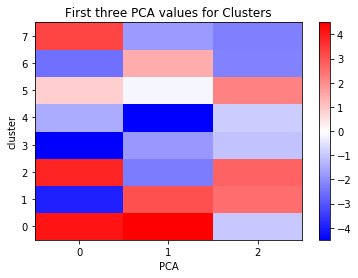

In [12]:
color_map = matplotlib.cm.get_cmap('bwr')

plt.pcolor(clusters_df, cmap=color_map, vmin=-4.5, vmax=4.5);
plt.title('First three PCA values for Clusters')
plt.ylabel('cluster')
plt.xlabel('PCA')

plt.yticks(np.arange(0.5, len(clusters_df.index)), clusters_df.index)
plt.xticks(np.arange(0.5, 3), clusters_df.index)

plt.colorbar()

plt.show()

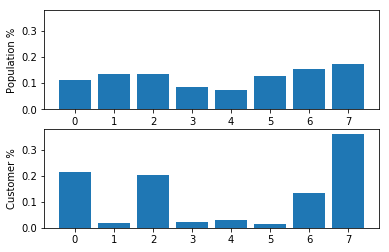

In [13]:
# Five clusters
get_cluster_props()

In [14]:
prop_diff=cust_p.sort_index()-cust_p2.sort_index()

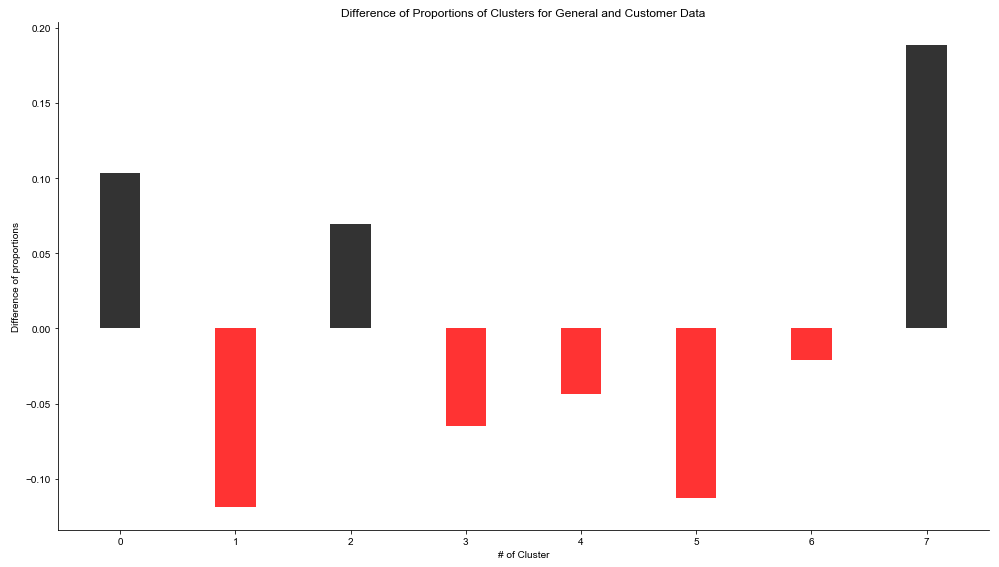

In [15]:
#Calculate differece of proportions
# prop_diff = cust_clust_freq[:, 2] - gen_clust_freq[:, 2]
positive= prop_diff > 0

# create plot
fig, ax = plt.subplots(figsize=(14, 8))
index =  np.arange(n_clusters)
bar_width = 0.35
# bar_width = 0.25
opacity = 0.8
 
diff = plt.bar(index, prop_diff, bar_width,
                 alpha=opacity,
                 color=np.vectorize({True: 'k', False: 'r'}.get)(positive)
              )

 
plt.xlabel('# of Cluster')
plt.ylabel('Difference of proportions')
plt.title('Difference of Proportions of Clusters for General and Customer Data')
plt.xticks(index)
 
plt.tight_layout()
sns.set(style="whitegrid")
sns.despine();

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

### Load all the datasets

In [16]:
feat_info =pd.read_csv('documented_features.csv', sep=',')
mailout_train_raw =pd.read_csv('Udacity_MAILOUT_052018_TRAIN.csv', sep=',')
mailout_test_raw =pd.read_csv('Udacity_MAILOUT_052018_TEST.csv', sep=',')
print(mailout_train_raw.shape)
print(mailout_test_raw.shape)

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(42962, 367)
(42833, 366)


### Data Processing
The below function clean and transform data into prediction-ready array

In [17]:
def clean_and_transform_data(raw_data, feature_dict):
    '''
    '''
    
    clean_df = raw_data.copy()
    feat_info = feature_dict.copy()
    # Parse missing_or_known string into a list
    feat_info['missing_or_unknown'] = feat_info['missing_or_unknown'].apply(lambda X:X[1:-1].split(','))
    
    #(1) Recoding variables and missing values
    # For the following columns, recode 10's to 0 
    # Reason:"no transactions known" is coded with number 10 while 1~9 indicates an ordinal magnitude
    recode = ['D19_BANKEN_DATUM', 'D19_BANKEN_OFFLINE_DATUM',
       'D19_BANKEN_ONLINE_DATUM', 'D19_GESAMT_DATUM',
       'D19_GESAMT_OFFLINE_DATUM', 'D19_GESAMT_ONLINE_DATUM',
       'D19_TELKO_DATUM', 'D19_TELKO_OFFLINE_DATUM',
       'D19_TELKO_ONLINE_DATUM','D19_VERSAND_DATUM',
             'D19_VERSAND_OFFLINE_DATUM','D19_VERSAND_ONLINE_DATUM']
    clean_df[recode] = clean_df[recode].replace(10, 0)
    
    recode2 = {1:0, 2:1, 3:0, 4:1, 5:0, 6:1, 7:1, 8:0, 9:1, 10:0, 11:1, 12:0, 13:1, 14:0, 15:1}
    clean_df['movement'] = clean_df['PRAEGENDE_JUGENDJAHRE'].replace(recode2)  
    clean_df.drop(['PRAEGENDE_JUGENDJAHRE'], axis=1, inplace=True)
    
    # According to the feature dictionary, all missing values should be recode as NAN for consistency
    missing_values = pd.Series(feat_info['missing_or_unknown'].values, index=feat_info.attribute).to_dict()
    clean_df[clean_df.isin(missing_values)] = np.nan
    
    
    # (2) drop variables with large number of missing values (more than 30% missing)
    to_drop = ['TITEL_KZ',
            'D19_TELKO_ONLINE_DATUM',
            'D19_BANKEN_OFFLINE_DATUM',
            'D19_TELKO_OFFLINE_DATUM',
            'D19_BANKEN_ONLINE_DATUM',
            'D19_BANKEN_DATUM',
            'D19_TELKO_DATUM',
            'KBA05_BAUMAX',
            'D19_VERSAND_ONLINE_DATUM',
            'D19_VERSAND_OFFLINE_DATUM',
            'D19_GESAMT_ONLINE_DATUM',
            'AGER_TYP',
            'D19_GESAMT_OFFLINE_DATUM',
            'WOHNLAGE',
            'GEBURTSJAHR'
           ]
    clean_df = clean_df.drop(to_drop, axis='columns')
    
     # (3) drop categorical variables with large number of levels and least indication to the response variable
    to_drop = ['CAMEO_DEU_2015',
            'LP_LEBENSPHASE_FEIN',
            'LP_FAMILIE_FEIN',
            'GFK_URLAUBERTYP',
            'LP_STATUS_FEIN',
            'D19_KONSUMTYP',
            'CJT_GESAMTTYP',
            'FINANZTYP',
            'GEBAEUDETYP',
            'LP_FAMILIE_GROB',
            'EINGEFUEGT_AM',
               'LNR'
           ]
    clean_df = clean_df.drop(to_drop, axis='columns')
    
    # (4) Type Conversion for on-hot encoding
    categorical_feat_cols =np.intersect1d(clean_df.columns.values, feat_info[(feat_info.type=='categorical')].attribute)
    clean_df[categorical_feat_cols]=clean_df[categorical_feat_cols].astype("object")
    clean_df = pd.get_dummies(clean_df)
    
    
    # (5) Impute missing values based on data types
    numerical_columns = feat_info[feat_info.type == 'numeric'].index
    numerical_columns = set(numerical_columns).intersection(set(clean_df.columns))
    categorical_columns = set(clean_df.columns).difference(numerical_columns)
    
    numerical_columns = list(numerical_columns)
    categorical_columns =list(categorical_columns)
    
    all_training_columns = numerical_columns + categorical_columns
       
   
    numerical_pipeline = make_pipeline(
                            SimpleImputer(strategy='median'),
                            StandardScaler())
    
    categorical_pipeline = make_pipeline(
                                SimpleImputer(strategy='most_frequent'))
    
    
    processing_pipeline = ColumnTransformer(
        [('numerical_preprocessing', numerical_pipeline, numerical_columns),
         ('categorical_preprocessing', categorical_pipeline, categorical_columns)],
        remainder='drop')
    
    # pandas dataframe would be converted as array after this step
    data_array = processing_pipeline.fit_transform(clean_df)

    return data_array, all_training_columns

In [18]:
y = mailout_train_raw.RESPONSE

mailout_train = mailout_train_raw.drop(['RESPONSE'], axis=1)
X_train=clean_and_transform_data(mailout_train, feat_info)[0]
print(X_train.shape)

X_test=clean_and_transform_data(mailout_test_raw, feat_info)[0]
print(X_test.shape)

(42962, 450)
(42833, 450)


In [19]:
all_training_columns =clean_and_transform_data(mailout_train, feat_info)[1]

### Modeling & Evaluation

In [20]:
gbm_estimator = lgb.LGBMClassifier(objective='binary', metric='auc')
gbm_estimator.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': 'binary',
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'metric': 'auc'}

In [21]:
param_grid = {'learning_rate': [0.01],
              'num_iterations': [200],
              'boosting_type': ['gbdt','dart'],
              'num_leaves': [62],
              'random_state': [42]}

start_time = time.time()

gbm_clf = GridSearchCV(estimator=gbm_estimator, param_grid=param_grid, scoring='roc_auc', cv=5)
gbm_result = gbm_clf.fit(X_train, y)

elapsed_time = (time.time() - start_time) / 60
print('Elapsed computation time: {:.3f} mins'.format(elapsed_time))

/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `n

Elapsed computation time: 0.980 mins


In [22]:
gbm_result
print(gbm_clf.best_score_)
print(gbm_clf.best_estimator_)

0.7641197373704546
LGBMClassifier(boosting_type='dart', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.01, max_depth=-1,
        metric='auc', min_child_samples=20, min_child_weight=0.001,
        min_split_gain=0.0, n_estimators=100, n_jobs=-1,
        num_iterations=200, num_leaves=62, objective='binary',
        random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


In [23]:
means = gbm_result.cv_results_['mean_test_score']
stds = gbm_result.cv_results_['std_test_score']
params = gbm_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

0.755408 (0.027004) with: {'boosting_type': 'gbdt', 'learning_rate': 0.01, 'num_iterations': 200, 'num_leaves': 62, 'random_state': 42}
0.764120 (0.020223) with: {'boosting_type': 'dart', 'learning_rate': 0.01, 'num_iterations': 200, 'num_leaves': 62, 'random_state': 42}


In [24]:
pickle.dump(gbm_clf.best_estimator_, open('lightgbm_model.pkl', 'wb'))

In [25]:
gbm_model = joblib.load('lightgbm_model.pkl')
pd.Series(gbm_model.feature_importances_, index=all_training_columns).sort_values(ascending=False).head(10)

D19_SOZIALES            396
VK_DISTANZ              239
EINGEZOGENAM_HH_JAHR    237
KBA05_HERST3            226
D19_KONSUMTYP_MAX       194
EXTSEL992               168
ALTERSKATEGORIE_FEIN    148
KBA13_ANZAHL_PKW        145
KBA05_ALTER1            143
KBA05_ZUL3              140
dtype: int64

### Model Output Analysis

In [26]:
feature = 'D19_SOZIALES'
totals = mailout_train_raw.groupby('RESPONSE')[feature].count()
counts = mailout_train_raw.groupby('RESPONSE')[feature].value_counts()
percentages = (counts/totals).unstack(level=0)
percentages

RESPONSE,0,1
D19_SOZIALES,,
0.0,0.274455,0.062640
1.0,0.303942,0.836689
2.0,0.042455,0.017897
3.0,0.246228,0.051454
4.0,0.091151,0.026846
5.0,0.041768,0.004474


The feature importances plot demonstrates that the most important feature is 'D19_SOZIALES', for which description is not available. Even though there is no information available about D19_SOZIALES specifically, Overall D19_* features are related to frequency of using certain group of products. Thus, the method distinguished two groups with high and low transaction activity.So people who are involved in this (D19_SOZIALES) kind of transaction are most likely to respond to the market campaign and become customer of the mail-order company.

The next important features are 'EINGESOGENAM_HH_JAHR ' and 'VK_DISTANZ'. Fortunately, the descriptions are not available either.And there are no other similar variables that help interpret their meaning. Would ask the mail-order company for more clarity.

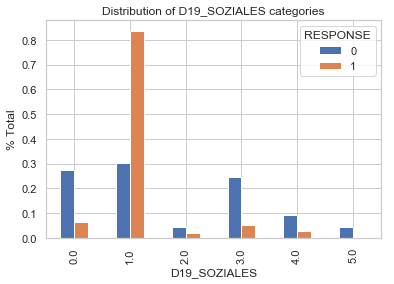

In [27]:
ax = percentages.plot.bar(title='Distribution of D19_SOZIALES categories')
ax.set(ylabel='% Total');

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [28]:
# lightgbm Boost
lnr = mailout_test_raw.LNR
preds = gbm_model.predict_proba(X_test)
data_submission = pd.DataFrame({'LNR':lnr, 'RESPONSE':preds[:,0]})
data_submission.to_csv('submission.csv', index=False)
data_submission.head()

,LNR,RESPONSE
0,1754,0.832231
1,1770,0.829404
2,1465,0.848011
3,1470,0.848007
4,1478,0.848014
